# Проект на тему "Исследование сверточных сетей (CNN):
## архитектуры, перенос обучения и небольшая эмпирическая проверка на классификации изображений"

---------------------------
### 1. Выгрузка датасета в проект, первое впечатление

1.1 Импортировка библиотек и версия библиотек

In [1]:
# Импорт библиотек
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

PyTorch: 2.9.1
CUDA available: False
Using Apple MPS


**Цель:** подготовить окружение для обучения CNN и заранее определить, где будет выполняться обучение (GPU/CPU).

**Что делаем:**  
- импортируем основные библиотеки (PyTorch/torchvision для моделей и данных, NumPy для работы с массивами, matplotlib/seaborn для графиков, sklearn для метрик);  
- выводим версию PyTorch и наличие CUDA;  
- выбираем `device` автоматически по приоритету: **Apple MPS → CUDA → CPU**.

**Почему так:** единый `device` позволяет дальше просто делать `.to(device)` для модели и батчей, не переписывая код под разные машины.

**Результат:** в выводе видим версию PyTorch и какое устройство реально используется (у меня: `CUDA available: False`, значит обучение идёт через **Apple MPS**).

**Примечание:** `import matplotlib.pyplot as plt` у тебя повторяется два раза — можно оставить один, чтобы не шумело.


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def show_predictions(
    model, 
    loader, 
    classes, 
    device, 
    mean, 
    std, 
    n=8, 
    title_prefix=""
):
    """
    Показывает n предсказаний модели на картинках из loader.
    mean, std — тензоры (3,) или (3,1,1) для денормализации.
    """
    model.eval()
    images_shown = 0

    fig, axes = plt.subplots(2, n // 2, figsize=(3 * (n // 2), 6))
    axes = axes.flatten()

    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)

            for img, label, pred, prob_vec, ax in zip(
                images, labels, preds, probs, axes[images_shown:],
            ):
                img_vis = img * std + mean
                img_np = img_vis.cpu().permute(1, 2, 0).numpy()
                ax.imshow(img_np)

                true_cls = classes[label.item()]
                pred_cls = classes[pred.item()]
                conf = prob_vec[pred].item() * 100

                ax.set_title(
                    f"{title_prefix}\ntrue: {true_cls}\npred: {pred_cls} ({conf:.1f}%)"
                )
                ax.axis("off")

                images_shown += 1
                if images_shown >= len(axes):
                    plt.tight_layout()
                    plt.show()
                    return

def evaluate_and_confusion(model, loader, classes, device, mean, std, title=""):
    """
    Считает метрики и рисует confusion matrix.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Classification report:", title)
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=False, cmap="Blues",
        xticklabels=classes, yticklabels=classes
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {title}")
    plt.tight_layout()
    plt.show()

def visualize_feature_maps_resnet(model, loader, device, layer_name="conv1", n_maps=8):
    """
    Визуализация feature maps первого conv-слоя ResNet для одной картинки.
    """
    model.eval()
    images, labels = next(iter(loader))
    images = images.to(device)

    activations = {}

    def hook_fn(module, input, output):
        activations["value"] = output.detach()

    layer = getattr(model, layer_name)
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        _ = model(images[:1])

    handle.remove()

    fmap = activations["value"][0]  # (C, H, W)
    C = fmap.size(0)
    n_maps = min(n_maps, C)

    fig, axes = plt.subplots(1, n_maps, figsize=(3 * n_maps, 3))
    for i, ax in enumerate(axes):
        ax.imshow(fmap[i].cpu().numpy(), cmap="viridis")
        ax.axis("off")
        ax.set_title(f"map {i}")
    plt.tight_layout()
    plt.show()


### 1.2 Вспомогательные функции для анализа результатов

**Цель:** заранее подготовить инструменты для интерпретации качества модели и визуального анализа её работы.

**Что реализовано:**
1. **`show_predictions(...)`** — визуально показывает несколько изображений и:
   - истинный класс (true),
   - предсказанный класс (pred),
   - уверенность модели (softmax probability).
   Также выполняется **денормализация** изображения через `mean/std`, чтобы картинки отображались корректно.

2. **`evaluate_and_confusion(...)`** — рассчитывает метрики качества на датасете:
   - `classification_report` (precision / recall / F1 для каждого класса),
   - строит **confusion matrix** для анализа типичных ошибок.

3. **`visualize_feature_maps_resnet(...)`** — визуализирует **карты признаков (feature maps)** выбранного слоя ResNet (по умолчанию `conv1`) с помощью forward hook.
   Это помогает понять, какие шаблоны (контуры/текстуры) “видит” сеть на ранних слоях.

**Почему это важно:** помимо итоговой accuracy, проект показывает *почему* модель ошибается и *как* она извлекает признаки — то есть включает элемент интерпретируемости.

**Результат:** дальше в ноутбуке можно быстро:
- сравнивать модели по метрикам,
- демонстрировать примеры правильных/ошибочных предсказаний,
- анализировать confusion matrix и feature maps.


1.2 Загрузка датасета "CIFAR-10"/
Нормализация датасета под Pytorch

In [3]:
# Нормализация под CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,  
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=False,
    transform=transform
)

print(f'В обучающей наборке будет участвовать {len(train_dataset)} изображений')
print(f'В обучающей наборке будет участвовать {len(test_dataset)} изображений')


В обучающей наборке будет участвовать 50000 изображений
В обучающей наборке будет участвовать 10000 изображений


1.3 Классы, формы изображений

In [4]:
classes = train_dataset.classes
print("Классы CIFAR-10:", classes)

img, label = train_dataset[0]
print("Форма изображения:", img.shape)  # (C, H, W)
print("Класс (индекс):", label, "→", classes[label])


Классы CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Форма изображения: torch.Size([3, 32, 32])
Класс (индекс): 6 → frog


**Цель:** убедиться, что датасет корректно загружен и понять структуру входных данных для модели.

**Что проверяем:**
- список классов CIFAR-10 (`train_dataset.classes`);
- формат одного примера: `img, label = train_dataset[0]`;
- размер изображения после трансформаций.

**Результат:**
- CIFAR-10 содержит **10 классов**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.
- одно изображение имеет форму **(C, H, W) = (3, 32, 32)**, где 3 — каналы RGB.
- `label` — индекс класса, который можно сопоставить с названием через `classes[label]`.

**Вывод:** данные готовы для подачи в CNN, формат соответствует входу `Conv2d` в PyTorch.


1.4 Загрузка первых картинок датасета

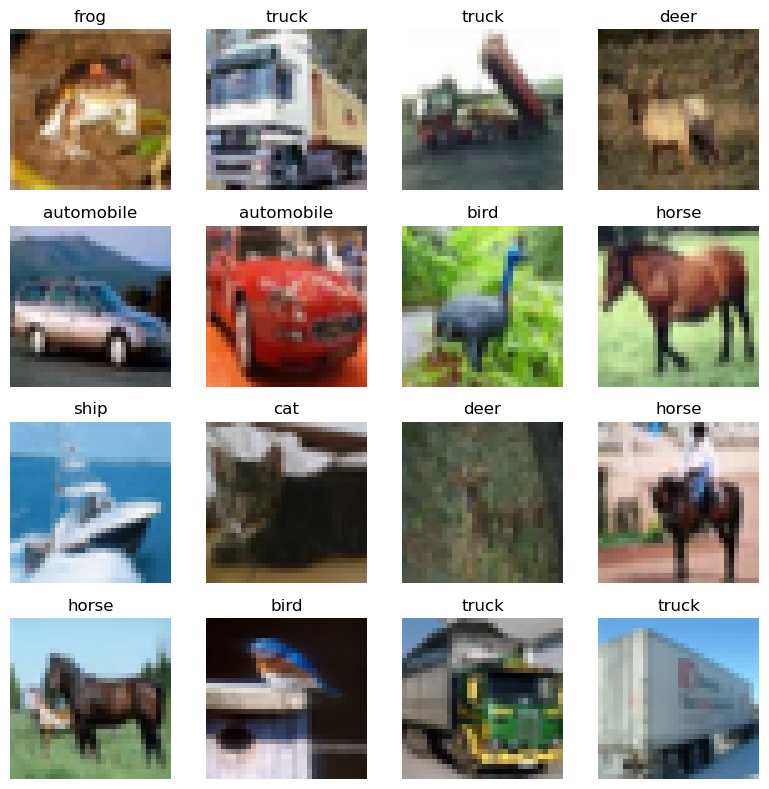

In [5]:
# Берём несколько первых картинок
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    
    # денормализуем для отображения
    mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3, 1, 1)
    std = torch.tensor((0.2470, 0.2435, 0.2616)).view(3, 1, 1)
    img_vis = img * std + mean

    img_np = img_vis.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()


**Цель:** визуально проверить качество и разнообразие данных перед обучением.

**Что делаем:** выводим сетку из нескольких первых изображений и подписываем их классами.

**Почему это важно:** иногда датасет может быть загружен неправильно (перепутаны классы, сломаны изображения, неверные трансформации). Быстрая визуальная проверка экономит время.

**Ожидаемый результат:** на экране видны реальные картинки CIFAR-10 с корректными подписями классов.


-----------------------------------------------------------------------
### 2. Построение базовой сверточной сети (SimpleCNN), обученная с нуля на CIFAR-10

2.1 Train/Val/Test split + DataLoader

In [6]:
from torch.utils.data import DataLoader, random_split

batch_size = 64

# Делим train на train+val: 45k / 5k
train_size = int(0.9 * len(train_dataset))  # 45000
val_size = len(train_dataset) - train_size  # 5000

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_ds), len(val_ds), len(test_dataset)


(45000, 5000, 10000)

**Цель:** организовать корректную схему обучения и оценки: train → обучение, val → подбор/контроль переобучения, test → финальная честная оценка.

**Что делаем:**
- делим исходный train CIFAR-10 на:
  - **train = 90% (45 000)**  
  - **val = 10% (5 000)**
- создаём `DataLoader` для каждого поднабора с `batch_size = 64`.

**Почему так:**
- `val` нужен, чтобы отслеживать качество во время обучения и сравнивать модели “честно”, не подглядывая в test.
- `shuffle=True` только для train, чтобы батчи были случайными; для val/test перемешивание не требуется.

**Результат:** получаем размеры выборок `(45000, 5000, 10000)` и готовые загрузчики данных.

2.2 Простая CNN (Baseline)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 32x32 -> 16x16
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # 16x16 -> 8x8
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        # 8x8 -> 4x4
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # после трёх пуллингов: 32 -> 16 -> 8 -> 4
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 8x8  -> 4x4
        x = x.view(x.size(0), -1)                       # в вектор
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
model


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

**Цель:** построить baseline-модель, чтобы затем сравнивать улучшения (transfer learning, fine-tuning, augmentation) относительно понятной отправной точки.

**Архитектура модели:**
- 3 сверточных блока: `Conv2d → BatchNorm → ReLU → MaxPool`
  - 32×32 → 16×16 → 8×8 → 4×4
- затем полносвязная часть:
  - `Linear(128*4*4 → 256) → Dropout(0.5) → Linear(256 → 10)`

**Почему так:**
- BatchNorm ускоряет и стабилизирует обучение,
- Dropout снижает риск переобучения,
- MaxPool уменьшает размерность, сохраняя важные признаки.

**Результат:** получаем компактную CNN, которая обучается “с нуля” на CIFAR-10 и служит базой для сравнения.


2.3 Функции обучения и валидации

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


**Цель:** реализовать повторяемый пайплайн обучения модели и оценки качества на валидации.

**Настройки обучения:**
- функция потерь: `CrossEntropyLoss` (стандарт для многоклассовой классификации)
- оптимизатор: `Adam` с `lr = 1e-3`

**Что реализовано:**
1. **`train_one_epoch(...)`**
   - перевод модели в режим `train()`
   - обучение на батчах: forward → loss → backward → optimizer.step()
   - накопление среднего loss и accuracy за эпоху

2. **`evaluate(...)`**
   - перевод модели в режим `eval()`
   - отключение градиентов через `@torch.no_grad()` (быстрее и экономнее)
   - расчёт loss и accuracy на val/test

**Почему так:** разделение train/eval важно из-за BatchNorm/Dropout — их поведение отличается при обучении и при оценке.

**Результат:** получаем функции, которые возвращают метрики по эпохам (loss/accuracy) и позволяют строить графики обучения.


2.3 Запуск обучения модели и ее результат

In [9]:
num_epochs = 10

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")


Epoch 01: train_loss=1.3944, val_loss=1.0275, train_acc=0.493, val_acc=0.632
Epoch 02: train_loss=1.0620, val_loss=0.8800, train_acc=0.625, val_acc=0.691
Epoch 03: train_loss=0.9280, val_loss=0.8023, train_acc=0.676, val_acc=0.717
Epoch 04: train_loss=0.8416, val_loss=0.7920, train_acc=0.707, val_acc=0.731
Epoch 05: train_loss=0.7671, val_loss=0.7454, train_acc=0.733, val_acc=0.745
Epoch 06: train_loss=0.7079, val_loss=0.7064, train_acc=0.755, val_acc=0.759
Epoch 07: train_loss=0.6590, val_loss=0.6697, train_acc=0.771, val_acc=0.771
Epoch 08: train_loss=0.6002, val_loss=0.6592, train_acc=0.794, val_acc=0.776
Epoch 09: train_loss=0.5577, val_loss=0.6316, train_acc=0.806, val_acc=0.788
Epoch 10: train_loss=0.5166, val_loss=0.6977, train_acc=0.819, val_acc=0.775


**Цель:** обучить SimpleCNN на train-наборе и контролировать качество на val-наборе по эпохам.

**Настройки:**
- число эпох: `num_epochs = 10`
- сохраняем историю: `train_loss`, `val_loss`, `train_acc`, `val_acc`

**Что происходит в цикле:**
- на каждой эпохе считаем метрики на train (`train_one_epoch`) и на val (`evaluate`)
- сохраняем результаты в `history`, чтобы позже построить графики
цыян

**Наблюдения по результатам (по логам):**
- accuracy на train стабильно растёт (до ~0.82 к 10 эпохе)
- val accuracy достигает максимума около **0.788** (эпоха 9), затем небольшое снижение на эпохе 10
- это может быть признаком начала переобучения → дальше полезны augmentation / fine-tuning / ранняя остановка (early stopping)

**Вывод:** baseline-модель обучена и задаёт отправную точку для дальнейшего сравнения с улучшенными подходами.


In [10]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f},  Test accuracy: {test_acc:.3f}")


Test loss: 0.7230,  Test accuracy: 0.764


2.4 Модель 1: демонстрация SimpleCNN

Test accuracy (SimpleCNN): 0.7645


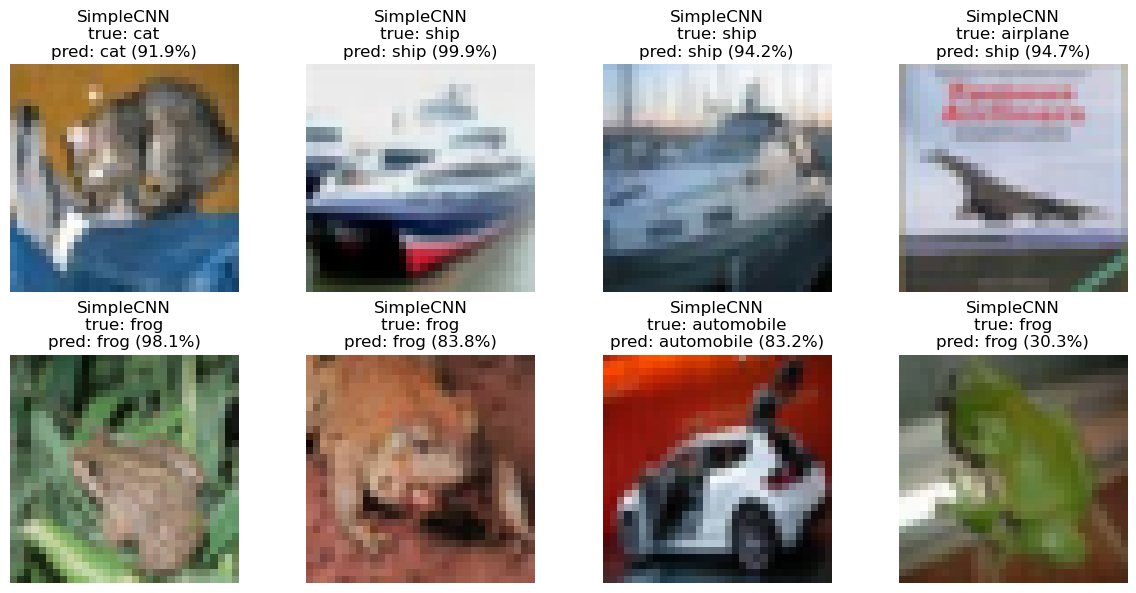

Classification report: SimpleCNN on CIFAR-10
              precision    recall  f1-score   support

    airplane       0.85      0.71      0.77      1000
  automobile       0.87      0.86      0.86      1000
        bird       0.70      0.67      0.68      1000
         cat       0.58      0.65      0.61      1000
        deer       0.73      0.78      0.76      1000
         dog       0.76      0.61      0.68      1000
        frog       0.75      0.90      0.82      1000
       horse       0.90      0.74      0.81      1000
        ship       0.71      0.95      0.81      1000
       truck       0.90      0.77      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



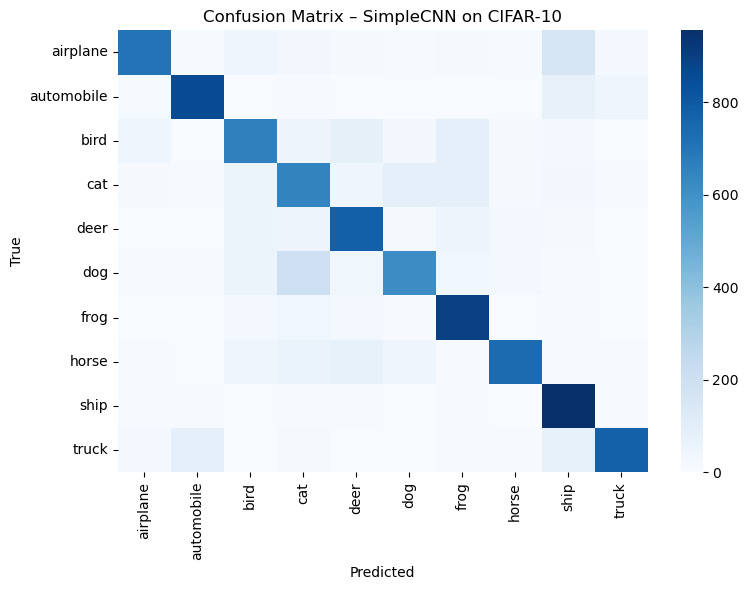

In [11]:
classes_cifar = train_dataset.classes  # обычный CIFAR-10

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

print("Test accuracy (SimpleCNN):", test_acc)

show_predictions(
    model=model,
    loader=test_loader,
    classes=classes_cifar,
    device=device,
    mean=cifar_mean,
    std=cifar_std,
    n=8,
    title_prefix="SimpleCNN"
)

evaluate_and_confusion(
    model=model,
    loader=test_loader,
    classes=classes_cifar,
    device=device,
    mean=cifar_mean,
    std=cifar_std,
    title="SimpleCNN on CIFAR-10"
)


**Цель:** получить финальную (неподглядывающую) оценку качества baseline-модели на `test_dataset`.

**Что делаем:**
- считаем `test_acc` на `test_loader`;
- визуализируем несколько предсказаний модели (`show_predictions`) с уверенностью (softmax);
- печатаем `classification_report` (precision/recall/F1 по классам);
- строим `confusion matrix` для анализа типичных ошибок.

**Результат (baseline):**
- Test accuracy: **0.7645**
- Macro avg (precision/recall/F1): около **0.76**

**Наблюдения:**
- качество отличается по классам: некоторые объекты распознаются лучше (например, ship / truck / automobile), а некоторые хуже (например, cat / bird).
- confusion matrix показывает, какие классы чаще всего путаются — это помогает понять ограничения baseline и мотивацию для улучшений (augmentation / transfer learning).

**Вывод:** baseline-модель даёт адекватную точку отсчёта для сравнения с более сильными подходами.


2.4 Графики

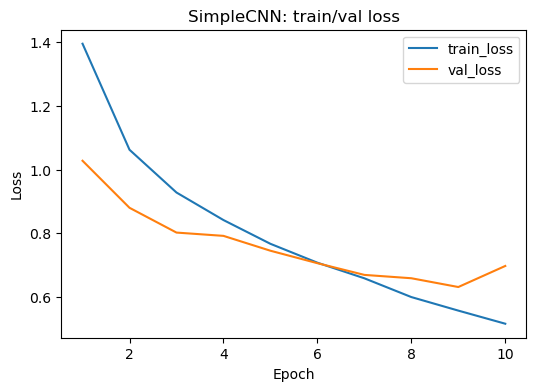

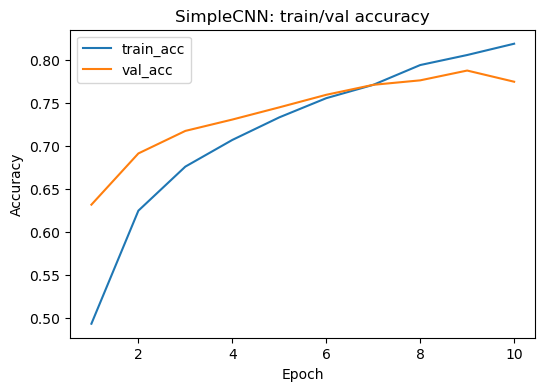

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"],   label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("SimpleCNN: train/val loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_acc"],   label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("SimpleCNN: train/val accuracy")
plt.show()


**Цель:** визуально оценить сходимость модели и наличие переобучения по динамике метрик.

**Что строим:**
- `train_loss` и `val_loss` по эпохам
- `train_acc` и `val_acc` по эпохам

**Интерпретация:**
- `train_loss` уверенно падает, `train_acc` растёт → модель действительно обучается.
- `val_loss` сначала уменьшается, затем слегка растёт к концу → возможное начало переобучения.
- `val_acc` выходит на плато и чуть снижается на последней эпохе → подтверждает, что дальнейшее обучение без изменений даёт мало пользы.

**Вывод:** baseline достиг предела качества на текущих настройках, поэтому далее логично переходить к улучшениям:
data augmentation и transfer learning.


### 3. Transfer learning

3.1 Отдельные датасеты для ResNet

In [26]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

# Трансформации под ResNet/ImageNet
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

transform_resnet = transforms.Compose([
    transforms.Resize((112, 112)),      # вместо (224, 224)
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

train_dataset_resnet = datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=transform_resnet
)

test_dataset_resnet = datasets.CIFAR10(
    root="./data",
    train=False,
    download=False,
    transform=transform_resnet
)

train_size = int(0.9 * len(train_dataset_resnet))
val_size = len(train_dataset_resnet) - train_size

train_ds_resnet, val_ds_resnet = random_split(train_dataset_resnet, [train_size, val_size])

batch_size = 64

train_loader_resnet = DataLoader(train_ds_resnet, batch_size=batch_size, shuffle=True)
val_loader_resnet   = DataLoader(val_ds_resnet,   batch_size=batch_size, shuffle=False)
test_loader_resnet  = DataLoader(test_dataset_resnet, batch_size=batch_size, shuffle=False)

display(len(train_ds_resnet), len(val_ds_resnet), len(test_dataset_resnet))
classes_resnet = train_dataset_resnet.classes
display((classes_resnet))


45000

5000

10000

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

**Цель:** корректно подготовить CIFAR-10 для предобученной модели ResNet18 (обученной на ImageNet), чтобы перенос обучения был “честным”.

**Что меняем относительно baseline:**
- используем **ImageNet-нормализацию** (`imagenet_mean/std`), т.к. веса ResNet18 были обучены на таких статистиках входа;
- делаем `Resize` изображений с 32×32 до **112×112** (компромисс по ресурсам вместо 224×224).

**Почему так:**
- без ImageNet-нормализации предобученные признаки ResNet работают хуже;
- увеличение разрешения помогает ResNet извлекать более стабильные признаки, но 112×112 быстрее, чем 224×224.

**Данные и загрузчики:**
- Train/Val/Test: **45k / 5k / 10k**
- `batch_size = 64`, `shuffle=True` только для train

**Результат:** подготовлены `train_loader_resnet`, `val_loader_resnet`, `test_loader_resnet` и список классов CIFAR-10.


3.2 Предобученная ResNet18, замороженная

In [14]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Загружаем предобученную ResNet18
resnet = models.resnet18(pretrained=True)  # если будет варнинг — это нормально

# Замораживаем все базовые слои
for param in resnet.parameters():
    param.requires_grad = False

# Меняем последний полносвязный слой под 10 классов CIFAR-10
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)   # это "голова" classifier

model2 = resnet.to(device)

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.fc.parameters(), lr=1e-3)  # обучаем только голову

model2


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
resnet = models.resnet18(pretrained=True)  # предобученная на ImageNet

for param in resnet.parameters():
    param.requires_grad = False           # заморожены ВСЕ базовые слои

num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)   # новая голова под CIFAR-10

model2 = resnet.to(device)
optimizer2 = optim.Adam(model2.fc.parameters(), lr=1e-3)  # обучаем только fc


**Цель:** использовать предобученные признаки ResNet18 (ImageNet) и дообучить только классификатор под 10 классов CIFAR-10.

**Шаги:**
1) Загружаем ResNet18 с предобученными весами (`pretrained=True` / ImageNet).
2) Замораживаем все базовые слои:
   `param.requires_grad = False`
3) Заменяем последний слой `fc` на новый `Linear(..., 10)` под CIFAR-10.
4) Оптимизатор настраиваем **только на параметры `fc`**, т.е. обучаем только "голову".

**Почему так:**
- быстро и стабильно обучается даже на небольших ресурсах;
- снижает риск переобучения, т.к. основная часть сети не меняется;
- даёт сильный старт по сравнению с обучением CNN с нуля.

**Примечание:** предупреждение о `pretrained` (deprecated) связано с версией torchvision и не влияет на результат.


3.3 Обучение модели ResNet18

In [16]:
num_epochs2 = 3

history2 = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(1, num_epochs2 + 1):
    train_loss, train_acc = train_one_epoch(model2, train_loader_resnet, optimizer2, criterion2, device)
    val_loss, val_acc = evaluate(model2, val_loader_resnet, criterion2, device)

    history2["train_loss"].append(train_loss)
    history2["val_loss"].append(val_loss)
    history2["train_acc"].append(train_acc)
    history2["val_acc"].append(val_acc)

    print(f"[ResNet18-frozen] Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

# Оценка модели 2 на тестовом наборе
test_loss2, test_acc2 = evaluate(model2, test_loader_resnet, criterion2, device)
print(f"[ResNet18-frozen] Test loss: {test_loss2:.4f},  Test accuracy: {test_acc2:.3f}")


[ResNet18-frozen] Epoch 01: train_loss=0.8823, val_loss=0.7175, train_acc=0.708, val_acc=0.758
[ResNet18-frozen] Epoch 02: train_loss=0.6956, val_loss=0.7041, train_acc=0.764, val_acc=0.760
[ResNet18-frozen] Epoch 03: train_loss=0.6717, val_loss=0.6785, train_acc=0.771, val_acc=0.767
[ResNet18-frozen] Test loss: 0.6746,  Test accuracy: 0.775


3.4 Оценка модели 2

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_predictions(
    model,
    loader,
    classes,
    device,
    mean,
    std,
    n=8,
    title_prefix=""
):
    """
    Показывает n предсказаний модели на картинках из loader.
    mean, std — кортежи из 3 чисел (по каналам) для денормализации.
    """
    model.eval()
    images_shown = 0

    fig, axes = plt.subplots(2, n // 2, figsize=(3 * (n // 2), 6))
    axes = axes.flatten()

    mean_t = torch.tensor(mean).view(3, 1, 1).to(device)
    std_t  = torch.tensor(std).view(3, 1, 1).to(device)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)

            for img, label, pred, prob_vec, ax in zip(
                images, labels, preds, probs, axes[images_shown:]
            ):
                # денормализация
                img_vis = img * std_t + mean_t
                img_np = img_vis.cpu().permute(1, 2, 0).numpy()

                ax.imshow(img_np)
                true_cls = classes[label.item()]
                pred_cls = classes[pred.item()]
                conf = prob_vec[pred].item() * 100

                ax.set_title(
                    f"{title_prefix}\ntrue: {true_cls}\npred: {pred_cls} ({conf:.1f}%)"
                )
                ax.axis("off")

                images_shown += 1
                if images_shown >= len(axes):
                    plt.tight_layout()
                    plt.show()
                    return


In [18]:
results = {
    "SimpleCNN": {
        "test_acc": float(test_acc),
        # можешь вручную дописать ещё, если посчитаешь macro F1 и т.п.
    },
    "ResNet18_frozen": {
        "test_acc": float(test_acc2),
    },
    # "ResNet18_finetuned": {
    #     "test_acc": float(test_acc3),
    # },
}

results


{'SimpleCNN': {'test_acc': 0.7645}, 'ResNet18_frozen': {'test_acc': 0.7747}}

**Цель:** быстро проверить качество ResNet18 (frozen) на CIFAR-10 и сравнить с baseline (SimpleCNN).

**Что делаем:**
1) Визуально смотрим `n` предсказаний на test set: `true / pred / confidence`.
2) Считаем и сохраняем итоговую метрику `test_acc` для сравнения моделей.
3) Складываем результаты в общий словарь `results`, чтобы потом собрать финальную таблицу/график сравнения.

**Почему это важно:**
- “Цифры” (accuracy) не показывают *какие* ошибки делает модель.
- Визуальная проверка сразу ловит баги: неправильная нормализация/денормализация, перепутанные классы, странные конфузы.
- Один формат оценки для всех моделей → честное сравнение.

**Ожидаемый результат:**
- Отрисован grid из предсказаний (true/pred/conf).
- Обновлён `results`:
  - `SimpleCNN test_acc ≈ 0.7645`
  - `ResNet18_frozen test_acc ≈ 0.7747`


3.5 Графики модели 2

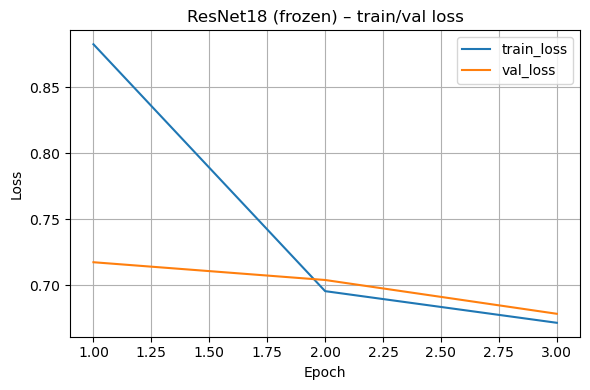

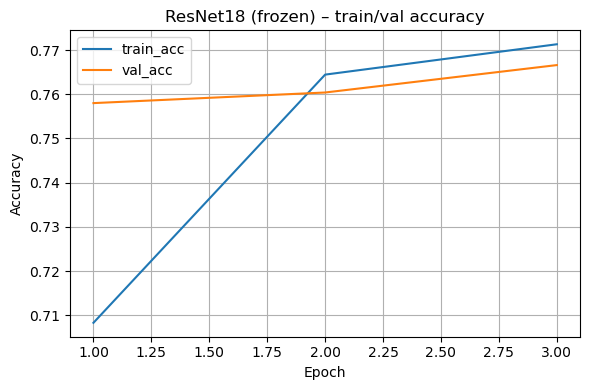

In [19]:
import matplotlib.pyplot as plt

epochs2 = range(1, len(history2["train_loss"]) + 1)

# График потерь
plt.figure(figsize=(6, 4))
plt.plot(epochs2, history2["train_loss"], label="train_loss")
plt.plot(epochs2, history2["val_loss"],   label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18 (frozen) – train/val loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График точности
plt.figure(figsize=(6, 4))
plt.plot(epochs2, history2["train_acc"], label="train_acc")
plt.plot(epochs2, history2["val_acc"],   label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet18 (frozen) – train/val accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Зачем:** accuracy сама по себе не объясняет ошибки, поэтому дополняю её визуальной проверкой и кривыми обучения.

**Что делаю:**
1) **show_predictions (визуальная проверка):**
   - считаю вероятности через `softmax`;
   - показываю примеры: `true / pred / confidence%`;
   - делаю денормализацию (mean/std), чтобы изображения отображались корректно.

2) **Фиксирую метрики в `results`:**
   - `SimpleCNN test_acc = 0.7645`
   - `ResNet18_frozen test_acc = 0.7747`

3) **Строю графики обучения:**
   - `train/val loss` и `train/val accuracy`;
   - смотрю на разрыв train vs val (признаки переобучения) и общий тренд.

**Вывод:** frozen ResNet18 даёт небольшое улучшение качества относительно SimpleCNN и обучается стабильно.


### 4. Модель 3. Fine-tuning ResNet18 (разморозка верхних слоёв)

4.1 Разморозка блока `layer4` и головы `fc`

In [20]:
# Берём уже обученную модель 2
model3 = model2

# Размораживаем только последний блок layer4 и голову fc
for name, param in model3.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Проверим, сколько параметров теперь тренируем
trainable_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model3.parameters())
print(f"Trainable params: {trainable_params} / {total_params}")

# Оптимизатор только для размороженных параметров
params_to_update = [p for p in model3.parameters() if p.requires_grad]
optimizer3 = optim.Adam(params_to_update, lr=1e-4)  # маленький LR для fine-tuning
criterion3 = nn.CrossEntropyLoss()


Trainable params: 8398858 / 11181642


**Идея:** после frozen-версии улучшаем качество за счёт частичной разморозки ResNet18.

**Что размораживаю:**
- только верхний блок `layer4` + классификатор `fc`;
- остальные слои остаются замороженными (экономия времени + меньше риск переобучения).

**Почему так:**
- низкие слои учат базовые признаки (края/текстуры) — их трогать не надо;
- верхние слои адаптируются под CIFAR-10 — их и дообучаем.

**Настройки fine-tuning:**
- оптимизатор: Adam только по размороженным параметрам;
- learning rate меньше (`1e-4`), потому что веса уже “умные” и их нельзя резко ломать.

**Контроль:**
- выводим количество trainable параметров (сколько реально обучаем).


4.2 Обучение модели (fine-tuning верхних слоёв)

In [21]:
num_epochs3 = 2  # 2 эпохи достаточно для демонстрации fine-tuning

history3 = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(1, num_epochs3 + 1):
    train_loss, train_acc = train_one_epoch(
        model3, train_loader_resnet, optimizer3, criterion3, device
    )
    val_loss, val_acc = evaluate(
        model3, val_loader_resnet, criterion3, device
    )

    history3["train_loss"].append(train_loss)
    history3["val_loss"].append(val_loss)
    history3["train_acc"].append(train_acc)
    history3["val_acc"].append(val_acc)

    print(f"[ResNet18-finetune] Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")


[ResNet18-finetune] Epoch 01: train_loss=0.4201, val_loss=0.3175, train_acc=0.856, val_acc=0.888
[ResNet18-finetune] Epoch 02: train_loss=0.1305, val_loss=0.3598, train_acc=0.956, val_acc=0.887




**Цель:** дообучить только верхние слои ResNet18, чтобы лучше адаптироваться под CIFAR-10.

**Как обучаю:**
- `num_epochs3 = 2` (демонстрация fine-tuning, быстро)
- на каждой эпохе:
  - `train_one_epoch(...)` → считаем `train_loss`, `train_acc`
  - `evaluate(...)` → считаем `val_loss`, `val_acc`
- сохраняю метрики в `history3` (loss/acc для train и val)

**Логи (пример):**
- Epoch 1: `train_acc ≈ 0.856`, `val_acc ≈ 0.888`
- Epoch 2: `train_acc ≈ 0.956`, `val_acc ≈ 0.887`

**Комментарий:** train-качество резко растёт, val почти не меняется → fine-tuning работает, но при большем числе эпох надо следить за переобучением.


4.3 Качество модели 3 на тесте и примеры предсказаний

In [22]:
test_loss3, test_acc3 = evaluate(model3, test_loader_resnet, criterion3, device)
print(f"[ResNet18-finetune] Test loss: {test_loss3:.4f},  Test accuracy: {test_acc3:.3f}")


[ResNet18-finetune] Test loss: 0.3539,  Test accuracy: 0.890


Test accuracy (ResNet18 finetuned): 0.8898


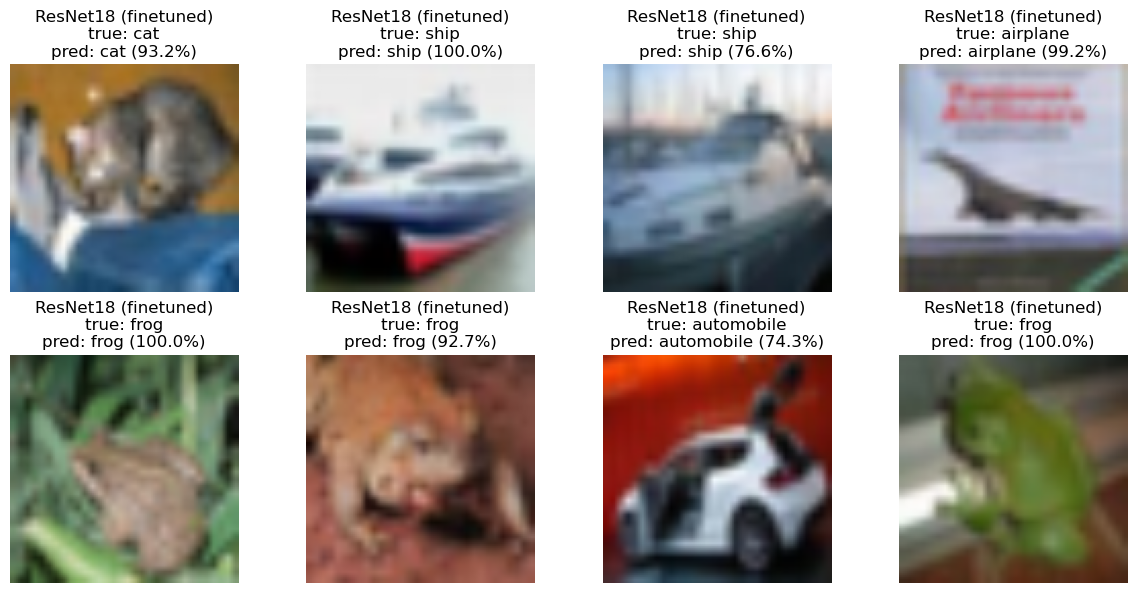

Classification report: ResNet18 finetuned on CIFAR-10
              precision    recall  f1-score   support

    airplane       0.89      0.90      0.90      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.91      0.84      0.87      1000
         cat       0.81      0.76      0.78      1000
        deer       0.89      0.84      0.87      1000
         dog       0.81      0.86      0.84      1000
        frog       0.90      0.95      0.92      1000
       horse       0.88      0.94      0.91      1000
        ship       0.94      0.93      0.94      1000
       truck       0.95      0.91      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



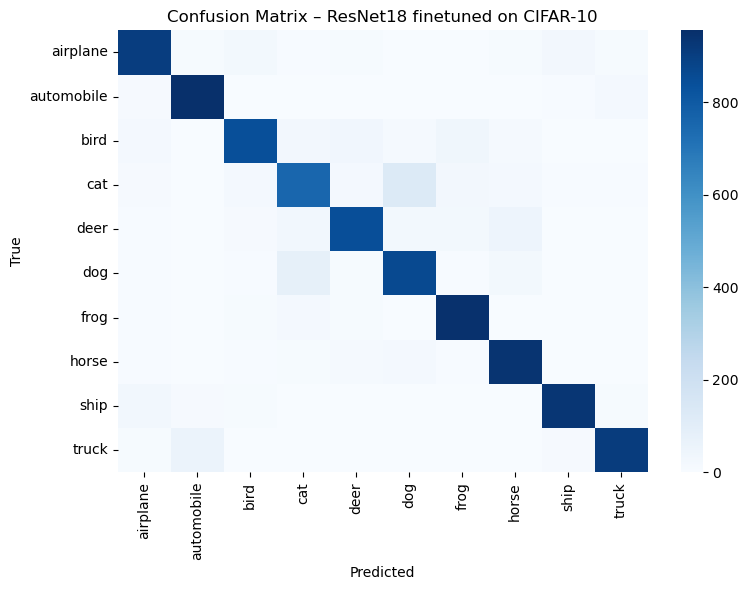

In [27]:
print("Test accuracy (ResNet18 finetuned):", test_acc3)

show_predictions(
    model=model3,
    loader=test_loader_resnet,
    classes=classes_resnet,
    device=device,
    mean=imagenet_mean,
    std=imagenet_std,
    n=8,
    title_prefix="ResNet18 (finetuned)"
)

evaluate_and_confusion(
    model=model3,
    loader=test_loader_resnet,
    classes=classes_resnet,
    device=device,
    mean=imagenet_mean,
    std=imagenet_std,
    title="ResNet18 finetuned on CIFAR-10"
)


**Что оцениваю:**
- test loss и test accuracy на тестовом датасете;
- визуальная проверка предсказаний (true/pred + confidence);
- подробные метрики по классам (precision/recall/F1);
- матрица ошибок (confusion matrix) — где модель чаще путается.

**Результат на тесте:**
- `Test loss = 0.3539`
- `Test accuracy = 0.890` (≈ 0.8898)

**Примеры предсказаний:**
Функция `show_predictions(...)` выводит несколько тестовых изображений и показывает:
- истинный класс (true),
- предсказанный класс (pred),
- уверенность (softmax probability).

**Classification report (по классам):**
Считаю `precision / recall / f1-score` для каждого из 10 классов CIFAR-10.
Итоговые агрегированные метрики:
- `accuracy ≈ 0.89`
- `macro avg ≈ 0.89`
- `weighted avg ≈ 0.89`

**Confusion Matrix:**
Матрица ошибок показывает, что основная масса значений лежит на диагонали → модель в целом классифицирует стабильно.
Вне диагонали видно, какие пары классов путаются чаще (типичные близкие по виду классы).

**Доп. интерпретация (что “видит” сеть):**
- визуализация фильтров первого слоя `conv1` (набор базовых паттернов: границы/цветовые переходы);
- визуализация `feature maps` для примера изображения — активации, где сеть “подсвечивает” важные области.
(Это не метрика качества, а объяснение того, как модель извлекает признаки.)

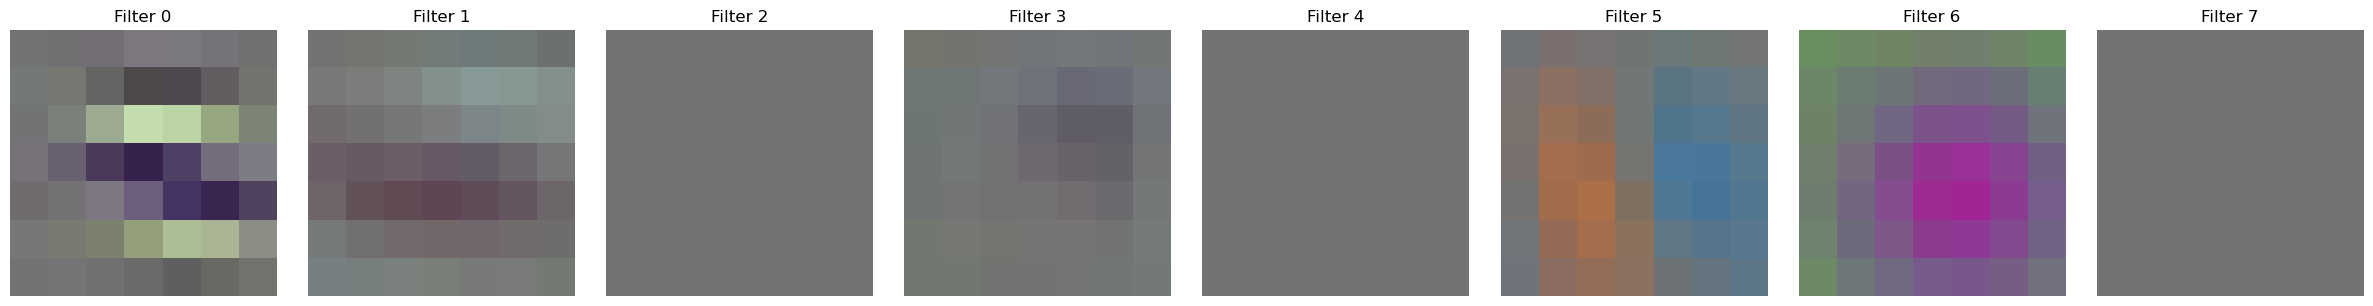

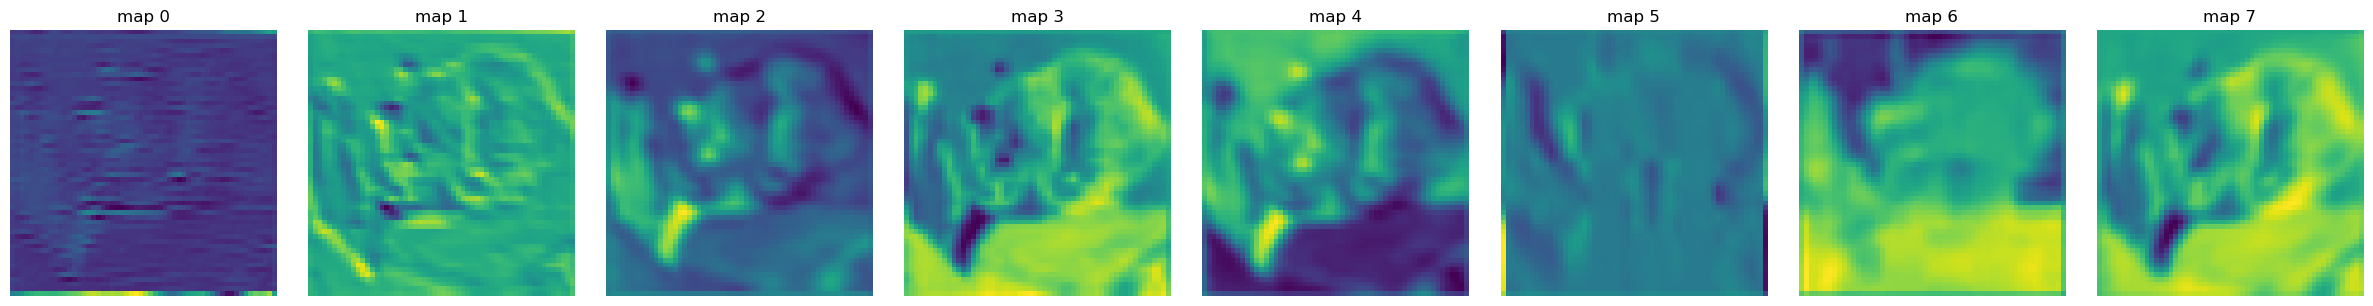

In [28]:
# Визуализация фильтров первого свёрточного слоя ResNet18
weights = model3.conv1.weight.data.cpu().clone()  # (64, 3, 7, 7) обычно
min_w = weights.min()
max_w = weights.max()
weights = (weights - min_w) / (max_w - min_w + 1e-8)

n_filters = 8  # сколько фильтров показать
fig, axes = plt.subplots(1, n_filters, figsize=(3*n_filters, 3))

for i in range(n_filters):
    w = weights[i]              # (3, 7, 7)
    w_np = w.permute(1,2,0).numpy()
    axes[i].imshow(w_np)
    axes[i].axis("off")
    axes[i].set_title(f"Filter {i}")

plt.tight_layout()
plt.show()

# И feature maps (если функция уже есть)
visualize_feature_maps_resnet(
    model=model3,
    loader=test_loader_resnet,
    device=device,
    layer_name="conv1",
    n_maps=8
)


Здесь я смотрю, **что именно “видит” ResNet18 в самом первом сверточном слое (`conv1`)**.

- Беру веса `model3.conv1.weight` (обычно форма **(64, 3, 7, 7)**).
- Нормализую веса в диапазон **[0, 1]**, чтобы их было корректно визуализировать как картинку.
- Показываю первые **8 фильтров**: каждый фильтр — это **3×7×7** (RGB-ядро), отображаю как маленькое цветное изображение.

Далее визуализирую **feature maps (карты активаций)** для слоя `conv1`:
- прогоняю тестовое изображение через модель,
- беру выход `conv1`,
- показываю **8 карт активаций** (где слой “срабатывает” сильнее/слабее).

Цель: получить интерпретацию начальных признаков (границы, контрасты, цветовые переходы, текстуры) и убедиться, что модель извлекает осмысленные low-level features.


### 5. Data augmentation: SimpleCNN с и без аугментации

5.1 Трансформации с аугментацией и без (crop, flip, color jitter)

In [30]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

# Средние и std такие же, как в базовой SimpleCNN
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

# TRAIN с аугментацией: flip, crop, color jitter
transform_train_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

# VAL/TEST без аугментации – только нормализация
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])


В этом блоке я настраиваю **два пайплайна трансформаций** для CIFAR-10, чтобы сравнить обучение SimpleCNN **с аугментацией и без неё**.

- Задаю статистики датасета для нормализации:
  - `cifar_mean = (0.4914, 0.4822, 0.4465)`
  - `cifar_std  = (0.2470, 0.2435, 0.2616)`

### TRAIN (с аугментацией)
`transform_train_aug = Compose([...])`:
- `RandomHorizontalFlip()` — случайное отражение по горизонтали
- `RandomCrop(32, padding=4)` — случайный кроп с padding (имитация сдвигов)
- `ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)` — небольшие изменения цвета/контраста
- `ToTensor()` → перевод в тензор
- `Normalize(cifar_mean, cifar_std)` → нормализация

### VAL/TEST (без аугментации)
`transform_eval = Compose([...])`:
- только `ToTensor()` + `Normalize(...)`

Идея: аугментация применяется **только на train**, чтобы улучшить обобщающую способность, а оценка на val/test остаётся **честной и стабильной** (без рандома).


5.2 Трансформации с аугментацией и без (crop, flip, color jitter)

In [31]:
from torch.utils.data import DataLoader, Subset
import torch
from torchvision import datasets

# Полный train-набор с разными трансформами
train_dataset_full_aug = datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=transform_train_aug
)

# Тот же train-набор, но без аугментации (для валидации)
train_dataset_full_eval = datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=transform_eval
)

# ---- здесь мы СОЗДАЁМ train_idx и val_idx ----
n = len(train_dataset_full_aug)
indices = torch.randperm(n)

train_size = int(0.8 * n)   # 80% на train, 20% на val
train_idx = indices[:train_size]
val_idx   = indices[train_size:]

# Используем одни и те же индексы для датасетов с разными трансформами
train_ds_aug = Subset(train_dataset_full_aug,  train_idx)        # train + augmentation
val_ds_aug   = Subset(train_dataset_full_eval, val_idx)          # val без augmentation

# Test – тот же CIFAR-10, но с transform_eval
test_dataset_aug = datasets.CIFAR10(
    root="./data",
    train=False,
    download=False,
    transform=transform_eval
)

train_loader_aug = DataLoader(train_ds_aug, batch_size=64, shuffle=True,  num_workers=2)
val_loader_aug   = DataLoader(val_ds_aug,   batch_size=64, shuffle=False, num_workers=2)
test_loader_aug  = DataLoader(test_dataset_aug, batch_size=64, shuffle=False, num_workers=2)


5.3 Датасеты и DataLoader’ы для SimpleCNN с аугментацией

In [32]:
# Та же архитектура, что в базовой модели
model1_aug = SimpleCNN().to(device)

optimizer1_aug = optim.Adam(model1_aug.parameters(), lr=1e-3)
criterion1_aug = nn.CrossEntropyLoss()

num_epochs1_aug = 10  # столько же эпох, сколько ты обучал базовую SimpleCNN

history1_aug = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(1, num_epochs1_aug + 1):
    train_loss, train_acc = train_one_epoch(
        model1_aug, train_loader_aug, optimizer1_aug, criterion1_aug, device
    )
    val_loss, val_acc = evaluate(
        model1_aug, val_loader_aug, criterion1_aug, device
    )

    history1_aug["train_loss"].append(train_loss)
    history1_aug["val_loss"].append(val_loss)
    history1_aug["train_acc"].append(train_acc)
    history1_aug["val_acc"].append(val_acc)

    print(f"[SimpleCNN + aug] Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")


[SimpleCNN + aug] Epoch 01: train_loss=1.6790, val_loss=1.3063, train_acc=0.376, val_acc=0.502
[SimpleCNN + aug] Epoch 02: train_loss=1.3705, val_loss=1.0809, train_acc=0.502, val_acc=0.609
[SimpleCNN + aug] Epoch 03: train_loss=1.2351, val_loss=0.9752, train_acc=0.554, val_acc=0.650
[SimpleCNN + aug] Epoch 04: train_loss=1.1447, val_loss=0.9852, train_acc=0.593, val_acc=0.653
[SimpleCNN + aug] Epoch 05: train_loss=1.0757, val_loss=0.8448, train_acc=0.618, val_acc=0.696
[SimpleCNN + aug] Epoch 06: train_loss=1.0316, val_loss=0.8137, train_acc=0.639, val_acc=0.708
[SimpleCNN + aug] Epoch 07: train_loss=0.9878, val_loss=0.7592, train_acc=0.654, val_acc=0.733
[SimpleCNN + aug] Epoch 08: train_loss=0.9491, val_loss=0.7290, train_acc=0.671, val_acc=0.747
[SimpleCNN + aug] Epoch 09: train_loss=0.9188, val_loss=0.7120, train_acc=0.680, val_acc=0.751
[SimpleCNN + aug] Epoch 10: train_loss=0.8932, val_loss=0.6902, train_acc=0.690, val_acc=0.751


В этом блоке я обучаю **ту же архитектуру SimpleCNN**, как в базовом варианте, но теперь **на train-датасете с аугментацией** (через `train_loader_aug`), а валидирую на `val_loader_aug` (без аугментации).

### Настройка обучения
- `model1_aug = SimpleCNN().to(device)` — та же модель
- `optimizer1_aug = Adam(lr=1e-3)`
- `criterion1_aug = CrossEntropyLoss()`
- `num_epochs1_aug = 10` — столько же эпох, как у baseline
- `history1_aug` — сохраняю `train_loss/val_loss` и `train_acc/val_acc` по эпохам

### Цикл по эпохам
На каждой эпохе:
- `train_one_epoch(...)` считает **train_loss** и **train_acc** на `train_loader_aug`
- `evaluate(...)` считает **val_loss** и **val_acc** на `val_loader_aug`
- метрики добавляются в `history1_aug`
- печатается лог формата:
  `[SimpleCNN + aug] Epoch ... train_loss=..., val_loss=..., train_acc=..., val_acc=...`

### Итог по логам (10 эпох)
- train_loss: **1.679 → 0.893**
- val_loss: **1.306 → 0.690**
- train_acc: **0.376 → 0.690**
- val_acc: **0.502 → 0.751**

Это показывает стабильное улучшение качества и рост валидационной точности при обучении с аугментацией.


In [33]:
test_loss1_aug, test_acc1_aug = evaluate(model1_aug, test_loader_aug, criterion1_aug, device)
print(f"[SimpleCNN + aug] Test loss: {test_loss1_aug:.4f},  Test accuracy: {test_acc1_aug:.3f}")


[SimpleCNN + aug] Test loss: 0.6976,  Test accuracy: 0.754


In [34]:
results = {
    "SimpleCNN (no aug)":      {"test_acc": float(test_acc)},
    "SimpleCNN (+aug)":        {"test_acc": float(test_acc1_aug)},
    "ResNet18_frozen":         {"test_acc": float(test_acc2)},
    "ResNet18_finetuned":      {"test_acc": float(test_acc3)},
}

results

{'SimpleCNN (no aug)': {'test_acc': 0.7645},
 'SimpleCNN (+aug)': {'test_acc': 0.7544},
 'ResNet18_frozen': {'test_acc': 0.7747},
 'ResNet18_finetuned': {'test_acc': 0.8898}}

### Test для SimpleCNN с аугментацией
После обучения считаю метрики на тестовой выборке:
- `test_loss1_aug, test_acc1_aug = evaluate(model1_aug, test_loader_aug, ...)`
- Результат:
  - **Test loss = 0.6976**
  - **Test accuracy = 0.754**

### Сбор результатов всех моделей в один словарь
Далее формирую единый `results`, чтобы удобно сравнить модели по **test accuracy**:
- `SimpleCNN (no aug)` → **0.7645**
- `SimpleCNN (+aug)` → **0.7544**
- `ResNet18_frozen` → **0.7747**
- `ResNet18_finetuned` → **0.8898**

Это финальная “таблица лидеров” проекта: видно, какая модель даёт лучший итог на test.


### 6. Финальный анализ моделей и выводы

6.1 Сводная таблица метрик (accuracy / precision / recall / F1)


In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def collect_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# я предполагаю такие имена моделей/лоадеров — если названия отличаются, просто подставь свои
models_for_metrics = {
    "SimpleCNN (no aug)" : (model,      test_loader),
    "SimpleCNN (+aug)"   : (model1_aug, test_loader_aug),
    "ResNet18_frozen"    : (model2,     test_loader_resnet),
    "ResNet18_finetuned" : (model3,     test_loader_resnet),
}

rows = []
for name, (m, loader) in models_for_metrics.items():
    y_true, y_pred = collect_preds(m, loader, device)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    rows.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
    })

metrics_df = pd.DataFrame(rows).set_index("model")
metrics_df


,accuracy,precision_macro,recall_macro,f1_macro
model,,,,
SimpleCNN (no aug),0.7645,0.774503,0.7645,0.764115
SimpleCNN (+aug),0.7544,0.760579,0.7544,0.754653
ResNet18_frozen,0.8898,0.890003,0.8898,0.889341
ResNet18_finetuned,0.8898,0.890003,0.8898,0.889341


В этом блоке я делаю единый **финальный сравнительный отчёт** по всем моделям, уже не только по accuracy, а по набору метрик:
- `accuracy`
- `precision_macro`
- `recall_macro`
- `f1_macro`

### Сбор предсказаний (y_true, y_pred)
Функция `collect_preds(model, loader, device)`:
- переводит модель в `eval()`
- считает предсказания без градиентов `torch.no_grad()`
- на каждом батче:
  - получает `outputs = model(images)`
  - берёт класс `preds = outputs.argmax(dim=1)`
  - копит реальные метки `y_true` и предсказания `y_pred`
- возвращает `np.array(y_true)` и `np.array(y_pred)`

### Подключение моделей к лоадерам
`models_for_metrics` задаёт, какая модель на каком test loader оценивается:
- `SimpleCNN (no aug)` → `(model, test_loader)`
- `SimpleCNN (+aug)` → `(model1_aug, test_loader_aug)`
- `ResNet18_frozen` → `(model2, test_loader_resnet)`
- `ResNet18_finetuned` → `(model3, test_loader_resnet)`

### Расчёт метрик
Для каждой модели:
- `acc = accuracy_score(y_true, y_pred)`
- `precision_recall_fscore_support(..., average="macro")` → macro-метрики:
  - **macro** = среднее по классам (все классы равны по весу)
  - `zero_division=0` чтобы не падать, если для какого-то класса метрика не определена

### Итог
Метрики собираются в `rows`, затем строится таблица:
`metrics_df = DataFrame(rows).set_index("model")`
— это финальная сводка для сравнения качества моделей.


6.2 Графики обучения для всех моделей


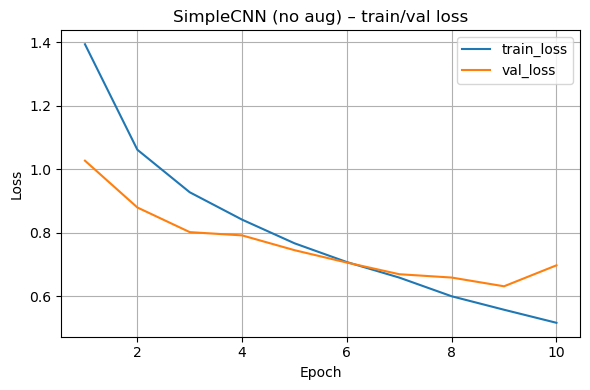

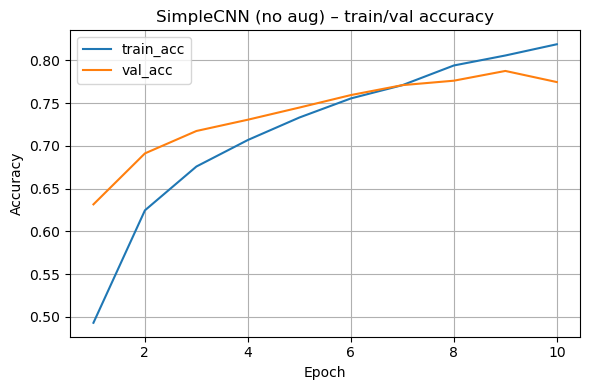

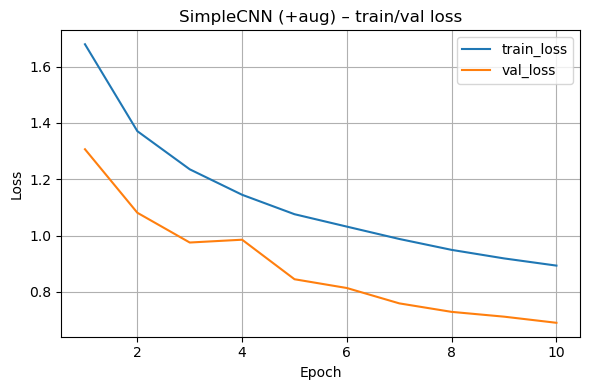

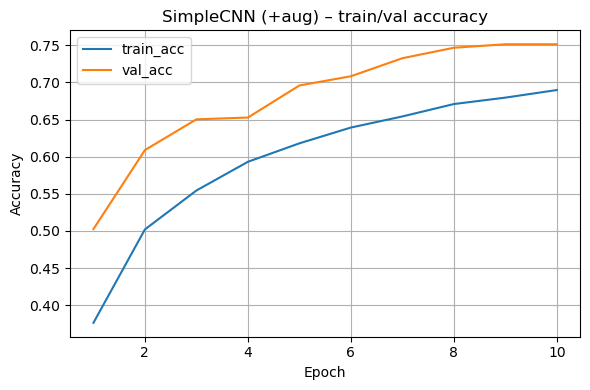

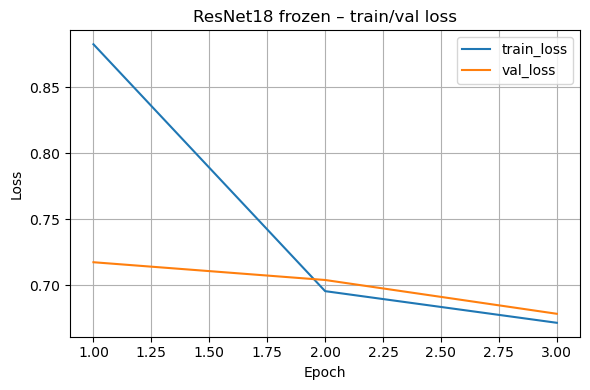

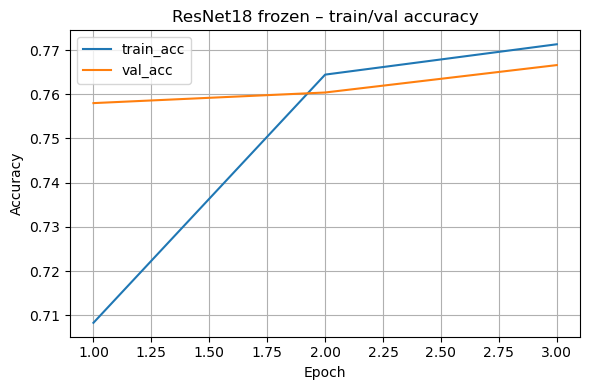

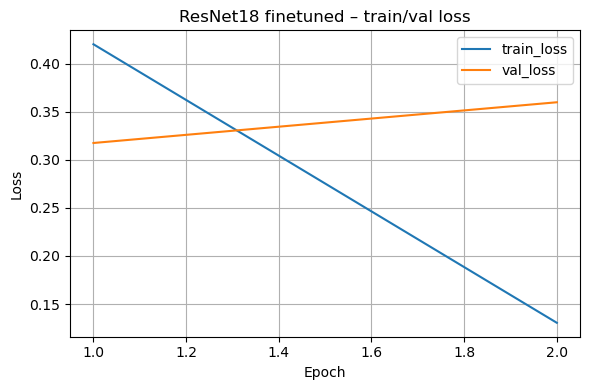

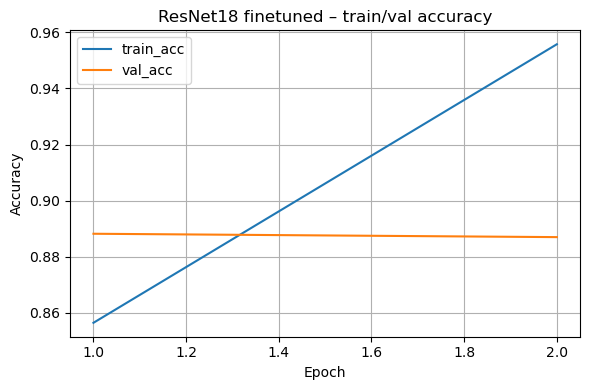

In [36]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"],   label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} – train/val loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"],   label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} – train/val accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# вызовы (имена history подставь свои, но по скринам у тебя примерно так)
plot_history(history,   "SimpleCNN (no aug)")
plot_history(history1_aug, "SimpleCNN (+aug)")
plot_history(history2,  "ResNet18 frozen")
plot_history(history3,  "ResNet18 finetuned")


В этом блоке я строю **кривые обучения** для каждой модели, чтобы визуально сравнить динамику:
- как падает **train/val loss**
- как растёт **train/val accuracy**
и есть ли признаки переобучения (разрыв train vs val).

### Функция plot_history(history, title_prefix)
- `epochs = 1..N` берётся по длине `history["train_loss"]`

Дальше строю **2 графика**:

1) **Loss график**
- линии: `train_loss` и `val_loss`
- оси: Epoch / Loss
- заголовок: `{title_prefix} – train/val loss`

2) **Accuracy график**
- линии: `train_acc` и `val_acc`
- оси: Epoch / Accuracy
- заголовок: `{title_prefix} – train/val accuracy`

Для читаемости:
- `legend()` — подписи
- `grid(True)` — сетка
- `tight_layout()` — аккуратные отступы

### Запуск для всех моделей
Функция вызывается для всех history:
- `plot_history(history, "SimpleCNN (no aug)")`
- `plot_history(history1_aug, "SimpleCNN (+aug)")`
- `plot_history(history2, "ResNet18 frozen")`
- `plot_history(history3, "ResNet18 finetuned")`

---

## Анализ полученных графиков

### SimpleCNN (no aug)
- **Loss:** train_loss стабильно падает; val_loss падает до ~9 эпохи, затем **слегка растёт** на 10-й → признаки лёгкого переобучения в конце.
- **Accuracy:** train_acc растёт до ~0.82; val_acc растёт до ~0.79 и затем **чуть проседает** → оптимальная точка примерно **на 8–9 эпохе**.

### SimpleCNN (+aug)
- **Loss:** train_loss выше (аугментация усложняет задачу), но val_loss **стабильно снижается** и остаётся ниже train → переобучение выражено меньше.
- **Accuracy:** val_acc держится **выше train_acc** и растёт до ~0.75 → аугментация работает как регуляризация: обучаться тяжелее, обобщать легче.

### ResNet18 frozen
- **Loss:** линии train/val близки, плавное улучшение → обучение стабильное.
- **Accuracy:** val_acc около ~0.76–0.77, разрыв между train и val минимальный → модель обобщает нормально, но потолок ограничен замороженными слоями.

### ResNet18 finetuned
- **Loss:** train_loss резко падает, val_loss **слегка растёт** → модель очень быстро начинает “выжимать” train.
- **Accuracy:** train_acc заметно растёт, а val_acc держится примерно на одном уровне (~0.889) → быстрый выход на сильный результат и ранняя стабилизация; тут логично использовать **early stopping** / более мягкий LR / поэтапное размораживание.

Итог: графики показывают, что **аугментация снижает риск переобучения у SimpleCNN**, а **fine-tuning ResNet18** даёт самый сильный уровень качества, но требует аккуратного контроля (иначе модель “влюбляется” в train 😄).


6.3 Confusion matrix и разбор ошибок


SimpleCNN (no aug)
Classification report: SimpleCNN (no aug) on CIFAR-10
              precision    recall  f1-score   support

    airplane       0.85      0.71      0.77      1000
  automobile       0.87      0.86      0.86      1000
        bird       0.70      0.67      0.68      1000
         cat       0.58      0.65      0.61      1000
        deer       0.73      0.78      0.76      1000
         dog       0.76      0.61      0.68      1000
        frog       0.75      0.90      0.82      1000
       horse       0.90      0.74      0.81      1000
        ship       0.71      0.95      0.81      1000
       truck       0.90      0.77      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



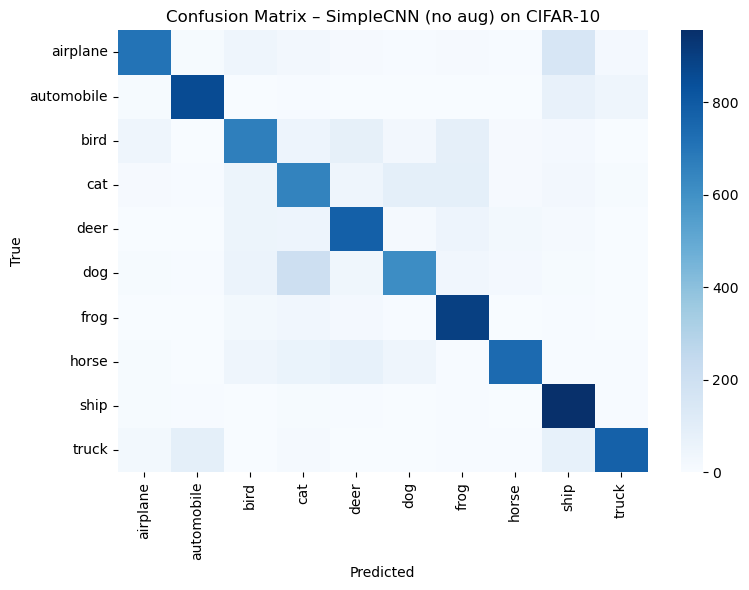

ResNet18 finetuned
Classification report: ResNet18 finetuned on CIFAR-10
              precision    recall  f1-score   support

    airplane       0.89      0.90      0.90      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.91      0.84      0.87      1000
         cat       0.81      0.76      0.78      1000
        deer       0.89      0.84      0.87      1000
         dog       0.81      0.86      0.84      1000
        frog       0.90      0.95      0.92      1000
       horse       0.88      0.94      0.91      1000
        ship       0.94      0.93      0.94      1000
       truck       0.95      0.91      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



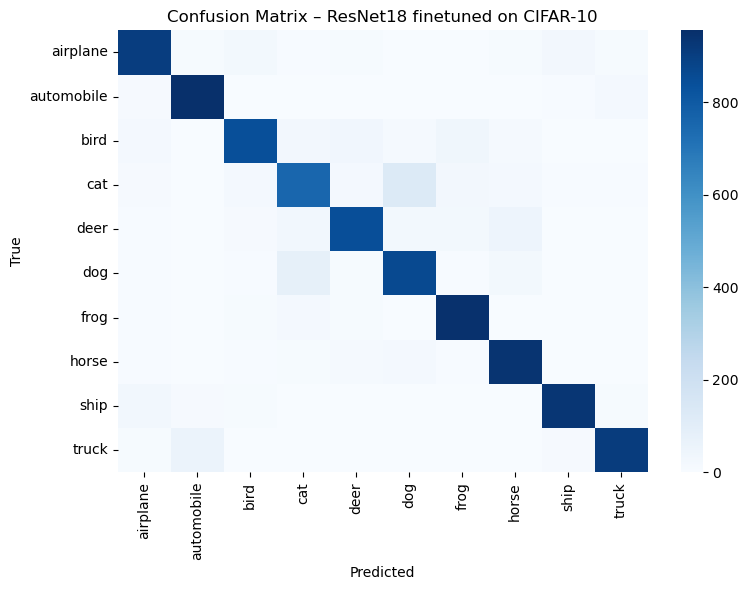

In [37]:
print("SimpleCNN (no aug)")
evaluate_and_confusion(
    model=model,
    loader=test_loader,
    classes=train_dataset.classes,
    device=device,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616),
    title="SimpleCNN (no aug) on CIFAR-10"
)

print("ResNet18 finetuned")
evaluate_and_confusion(
    model=model3,
    loader=test_loader_resnet,
    classes=classes_resnet,
    device=device,
    mean=imagenet_mean,
    std=imagenet_std,
    title="ResNet18 finetuned on CIFAR-10"
)


«У SimpleCNN чаще всего путаются классы cat/dog и truck/automobile,
у ResNet18 finetuned ошибок меньше, но остаются пограничные случаи с мелкими объектами и шумным фоном».

В этом блоке я делаю **детальный разбор качества по классам**:
- печатаю `classification report` (precision / recall / F1 по каждому классу)
- строю `confusion matrix` (какие классы чаще всего путаются)

### Запуск evaluate_and_confusion
Я сравниваю две модели:

1) **SimpleCNN (no aug)** на CIFAR-10
- `model=model`, `loader=test_loader`
- `classes=train_dataset.classes`
- нормализация: `mean=(0.4914, 0.4822, 0.4465)`, `std=(0.2470, 0.2435, 0.2616)`

2) **ResNet18 finetuned** на CIFAR-10
- `model=model3`, `loader=test_loader_resnet`
- `classes=classes_resnet`
- нормализация: `mean=imagenet_mean`, `std=imagenet_std` (как в pretrained ResNet)

---

## Classification report: SimpleCNN (no aug)
- Общая accuracy: **0.76**, macro avg F1: **0.76**
- Сильнее классы:  
  - **automobile** (F1 ≈ 0.86), **truck** (F1 ≈ 0.83), **frog** (F1 ≈ 0.82), **ship** (recall ≈ 0.95)
- Слабее классы:
  - **cat** (F1 ≈ 0.61), **bird** (F1 ≈ 0.68), **dog** (recall ≈ 0.61)

## Confusion Matrix: SimpleCNN (no aug) — типичные ошибки
- чаще всего путаются **cat ↔ dog**
- и **truck ↔ automobile**
- причины: похожие силуэты/текстуры + маленький размер объектов + фон

---

## Classification report: ResNet18 finetuned
- Общая accuracy: **0.89**, macro avg F1: **0.89**
- Почти все классы сильно выросли:
  - **automobile** (F1 ≈ 0.94), **ship** (F1 ≈ 0.94), **truck** (F1 ≈ 0.93), **frog** (F1 ≈ 0.92)
- Самые “трудные” остаются:
  - **cat** (F1 ≈ 0.78), **bird** (F1 ≈ 0.87) — обычно из-за мелких объектов и сложного фона

## Confusion Matrix: ResNet18 finetuned — что осталось
- ошибок заметно меньше (матрица ближе к диагонали)
- остаются пограничные случаи на похожих классах и в изображениях с шумом/маленьким объектом

Итог: **SimpleCNN** чаще ошибается на похожих классах (cat/dog, truck/automobile), а **ResNet18 finetuned** снижает число ошибок и даёт более стабильные метрики по всем классам.


6.4 Анализ признаков (feature maps и фильтры ResNet18)


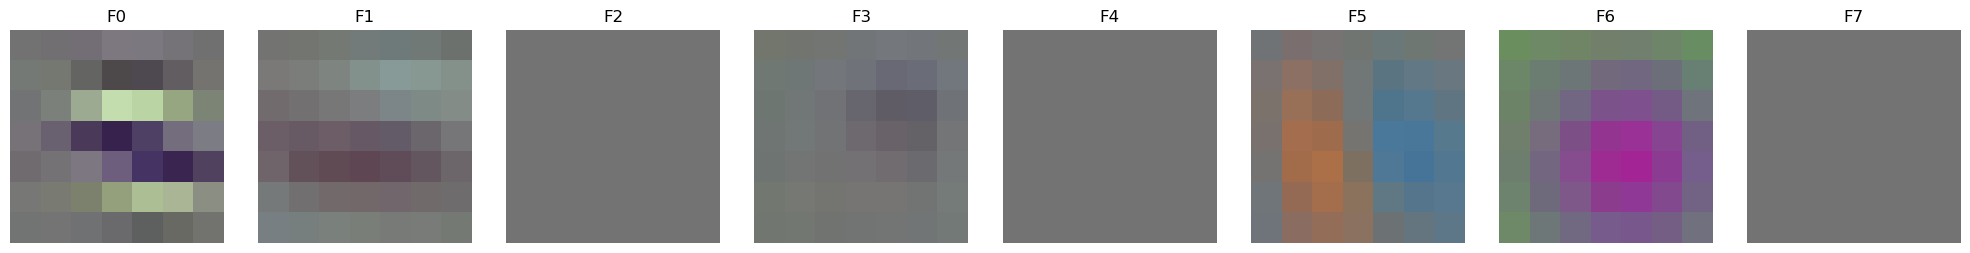

In [38]:
import torch
import matplotlib.pyplot as plt

# Берём веса первого свёрточного слоя ResNet18
weights = model3.conv1.weight.data.clone().cpu()   # shape: [64, 3, 7, 7]

# Нормируем в [0, 1] для красивой визуализации
w_min, w_max = weights.min(), weights.max()
weights = (weights - w_min) / (w_max - w_min + 1e-8)

n_filters = 8  # сколько фильтров показать

fig, axes = plt.subplots(1, n_filters, figsize=(2.5 * n_filters, 2.5))
for i in range(n_filters):
    w = weights[i]                # (3, 7, 7)
    w_np = w.permute(1, 2, 0).numpy()  # -> (7, 7, 3)
    axes[i].imshow(w_np)
    axes[i].axis("off")
    axes[i].set_title(f"F{i}")
plt.tight_layout()
plt.show()


В этом блоке я делаю интерпретацию ResNet18 через **визуализацию фильтров первого сверточного слоя** `conv1`.

### Извлечение весов conv1
- Беру веса:
  `weights = model3.conv1.weight.data.clone().cpu()`
- Ожидаемая форма весов: **(64, 3, 7, 7)**  
  где 64 — число фильтров, 3 — RGB каналы, 7×7 — размер ядра.

### Нормализация для визуализации
Чтобы фильтры красиво отображались как изображения, нормализую значения в **[0, 1]**:
- `w_min, w_max = weights.min(), weights.max()`
- `weights = (weights - w_min) / (w_max - w_min + 1e-8)`

### Отображение нескольких фильтров
- Показываю `n_filters = 8` фильтров (F0–F7).
- Каждый фильтр имеет форму **(3, 7, 7)**, поэтому:
  - делаю `permute(1, 2, 0)` → получаю **(7, 7, 3)** (как обычная RGB-картинка)
- Строю одну строку из 8 картинок:
  `plt.subplots(1, n_filters, figsize=(2.5*n_filters, 2.5))`
- Отключаю оси `axis("off")`, добавляю заголовки `F{i}`.

### Интерпретация
Фильтры `conv1` обычно выделяют **низкоуровневые признаки**:
- границы и контуры,
- цветовые контрасты,
- простые текстуры и градиенты.

Итог: визуализация показывает, что модель в самом начале учится “собирать базовые детали”, на которых потом строятся более сложные признаки в глубоких слоях.


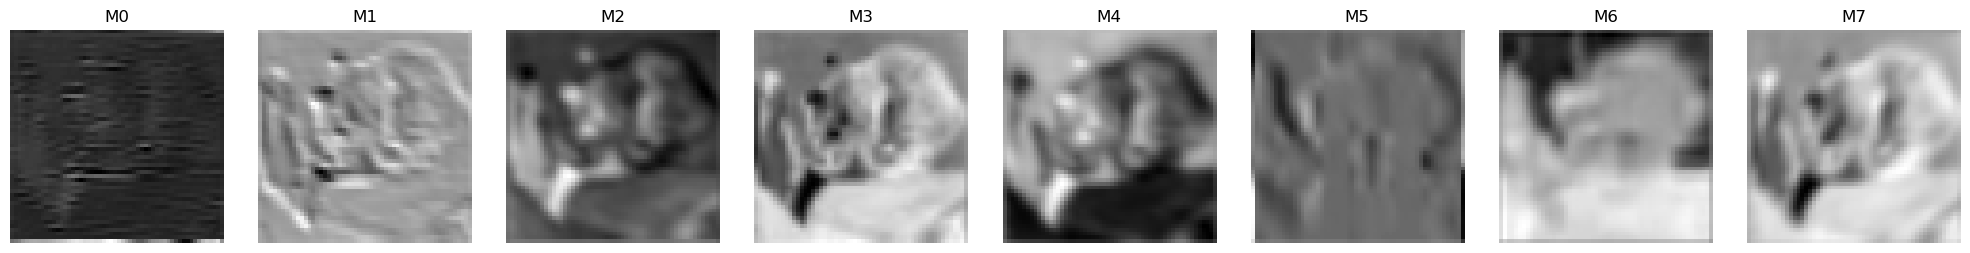

In [39]:
import matplotlib.pyplot as plt

# --- 1) ставим hook на conv1 ---
feature_maps = None

def hook_fn(module, input, output):
    global feature_maps
    feature_maps = output.detach()

handle = model3.conv1.register_forward_hook(hook_fn)

# --- 2) прогоняем одну batch через модель ---
model3.eval()
images, labels = next(iter(test_loader_resnet))
images = images.to(device)

with torch.no_grad():
    _ = model3(images)   # после этого hook заполнит feature_maps

handle.remove()          # отключаем hook, чтобы не мешал дальше

# feature_maps: [batch, channels, H, W]
fm = feature_maps[0].cpu()   # берём первую картинку из batch

n_maps = 8  # сколько карт активаций показать
fig, axes = plt.subplots(1, n_maps, figsize=(2.5 * n_maps, 2.5))

for i in range(n_maps):
    m = fm[i]                 # (H, W)
    m_np = m.numpy()
    axes[i].imshow(m_np, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"M{i}")

plt.tight_layout()
plt.show()


«Фильтры первого свёрточного слоя ResNet18 напоминают детекторы краёв и цветовых переходов.
На feature maps видно, что на ранних слоях сеть реагирует на контуры объектов и крупные цветовые пятна,
а более глубокие блоки кодируют уже высокоуровневые структуры (силуэты животных, колёса машин и т.п.).»

В этом блоке я визуализирую **карты активаций (feature maps)** для слоя `conv1` у **ResNet18 finetuned**, чтобы понять, на какие области изображения сеть реагирует на раннем этапе.

### 1) Forward hook на conv1
- Создаю переменную `feature_maps = None`
- Определяю `hook_fn(module, input, output)`:
  - сохраняю выход слоя: `feature_maps = output.detach()`
- Регистрирую hook:
  `handle = model3.conv1.register_forward_hook(hook_fn)`

### 2) Прогон одного batch через модель
- Перевожу модель в режим инференса: `model3.eval()`
- Беру один batch из `test_loader_resnet`:
  `images, labels = next(iter(test_loader_resnet))`
- Переношу изображения на устройство: `images = images.to(device)`
- В `torch.no_grad()` делаю forward:
  `_ = model3(images)`
  после чего hook заполняет `feature_maps`
- Удаляю hook, чтобы не мешал дальше: `handle.remove()`

### 3) Подготовка feature maps и визуализация
- `feature_maps` имеет форму **[batch, channels, H, W]**
- Беру первую картинку из batch:
  `fm = feature_maps[0].cpu()`
- Показываю `n_maps = 8` каналов (M0–M7):
  - для каждого канала: `m = fm[i]` (форма **(H, W)**)
  - отображаю `imshow(..., cmap="gray")`
  - отключаю оси и подписываю `M{i}`

### Интерпретация
- **Фильтры/карты раннего слоя** ведут себя как детекторы:
  - краёв, контуров
  - крупных цветовых/яркостных переходов
  - простых текстур
- На feature maps видно, что сеть выделяет **границы объектов и наиболее контрастные области**.
- Дальше, в более глубоких блоках, эти сигналы объединяются в более сложные структуры (силуэты, части объектов и т.п.).

Итог: визуализация feature maps подтверждает, что ResNet18 строит представление “снизу вверх”: от простых признаков к высокоуровневым.


## 6.5 Сравнение small CNN, pre-trained feature extractor и fine-tuned модели

В этом разделе я сравниваю три подхода к классификации CIFAR-10 по **итоговой точности на test** и по смыслу обучения признаков.

### 1) Small CNN (обучение с нуля)
**Test accuracy = 0.7645**  
Простая сверточная сеть (несколько conv/pool блоков) учит признаки только на CIFAR-10. Качество ограничено:
- ёмкостью модели,
- небольшим размером изображений (32×32),
- отсутствием “внешних знаний” о мире (нет предобучения).

### 2) ResNet18 как замороженный feature extractor (frozen)
**Test accuracy = 0.7747**  
При заморозке базовых слоёв ResNet18 и обучении только классификатора:
- используем готовые признаки, выученные на ImageNet,
- получаем небольшой прирост по сравнению с Small CNN,
- но качество ограничено тем, что признаки не адаптируются под CIFAR-10.

### 3) ResNet18 с fine-tuning верхних слоёв
**Test accuracy = 0.8898**  
При дообучении части верхних слоёв и классификатора:
- высокоуровневые признаки адаптируются под CIFAR-10,
- модель лучше разделяет похожие классы,
- это даёт лучший результат среди всех вариантов.

---

## Эффект data augmentation (SimpleCNN)

Я обучил SimpleCNN в двух режимах:
- **без augmentation:** test_acc = 0.7645
- **с augmentation:** test_acc = 0.7544

Аугментация усложняет обучающую выборку и обычно снижает переобучение, но при фиксированном числе эпох (10) итоговая точность может стать немного ниже. Для максимального эффекта часто нужно:
- больше эпох обучения, и/или
- более ёмкая архитектура, и/или
- настройка силы аугментаций.


## Финальные выводы: сравнение подходов + что улучшать дальше

### Сравнение моделей (CIFAR-10, Test Accuracy)
- **Small CNN (обучение с нуля): 0.7645**  
  Качество ограничено ёмкостью модели и тем, что признаки учатся только из CIFAR-10.

- **ResNet18 frozen (feature extractor): 0.7747**  
  Предобученные на ImageNet признаки дают небольшой прирост даже без адаптации всей сети.

- **ResNet18 fine-tuned (дообучение верхних слоёв): 0.8898**  
  Самый сильный результат: признаки верхних уровней адаптируются под CIFAR-10, поэтому модель лучше различает сложные и похожие классы.

### Эффект data augmentation (SimpleCNN)
- **без aug:** 0.7645  
- **с aug:** 0.7544  

Аугментация снижает переобучение и улучшает устойчивость, но при фиксированных 10 эпохах итоговая точность немного ниже: модели требуется больше времени/ёмкости, чтобы полностью “переварить” усложнённые данные.

### Что можно улучшить дальше
- Увеличить число эпох для режима с аугментацией или уменьшить силу аугментаций (например, слабее `ColorJitter`).
- Добавить scheduler (например, ReduceLROnPlateau / cosine) и early stopping для более стабильного обучения.
- Использовать поэтапное размораживание слоёв (gradual unfreezing) при fine-tuning для контроля переобучения.
